# **Model Evaluation**

**Goal** <br>
Load the weights from a trained model to create a function capable of making predictions on synthetic data.

# **Import Statements**

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib, scipy
from numba import jit
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.signal import find_peaks
from collections import deque
from joblib.externals.loky import set_loky_pickler
from joblib import parallel_backend
from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects

#suppress annoying tensorflow warnings
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


print("Tensorflow Version: " +  tf.__version__)
print("Numpy Version: "  + np.__version__)
print("Matplotlib Version: " + matplotlib.__version__)
print("Scipy Version: " + scipy.__version__)

Tensorflow Version: 2.9.2
Numpy Version: 1.23.4
Matplotlib Version: 3.6.2
Scipy Version: 1.9.3


# **Synthetic Data Generation**

**Loading Data**

In [2]:
datadir  = 'Mazin Lab/ML Pulse Analysis for MKIDs/' #this line is the filepath on my computer's file system

def plotPulse(I,Q,I_trace,Q_trace):
  plt.plot(I,Q)
  plt.title('I Q data')
  plt.show()
  plt.title('I Q trace data')
  plt.scatter(I_trace,Q_trace,s=0.25,c='red')

# Load sweep data
sweep = np.load(datadir+'sweep.npz')
f = sweep['f']
z = sweep['z']
I = z.real
Q = z.imag


# Load all wavelengths
fnames = ['808nm.npz','920nm.npz','980nm.npz','1120nm.npz','1310nm.npz']
i_trace = deque()
q_trace = deque()
peak_heights = deque()
peak_indices = deque()
filtered_data = deque()
for i in range(5):
    data = np.load(datadir+fnames[i])
    i_trace.append(data['i_trace'])
    q_trace.append(data['q_trace'])
    filtered_data.append(data['filtered_data'])
    peak_heights.append(data['peak_heights'])
    peak_indices.append(data['peak_indices'])
    data_size = data['i_trace'][:,0].size

i_trace = np.array(i_trace)
q_trace = np.array(q_trace)
filtered_data = np.array(filtered_data)

# Create Fake Data Stream
SampRate = 2000000       # Sample rate is 2 MHz
TrainingTime = 0.1      # Training data set length in sec
PhotonRate = 1000.0      # Photon Arrival rate in photons/sec
N_time_datapoints = int(SampRate*TrainingTime) #Number of datapoints based on the training time and sample rate
photon_prob = PhotonRate/SampRate #The probability that a photon is incident at a given time_datapoint


i_train=np.zeros(N_time_datapoints)
q_train=np.zeros(N_time_datapoints)
label=np.zeros(N_time_datapoints)
peaks=np.zeros(N_time_datapoints,dtype=int)
time = np.linspace(0,TrainingTime,N_time_datapoints)



**Mapping Function + Data Visualization**

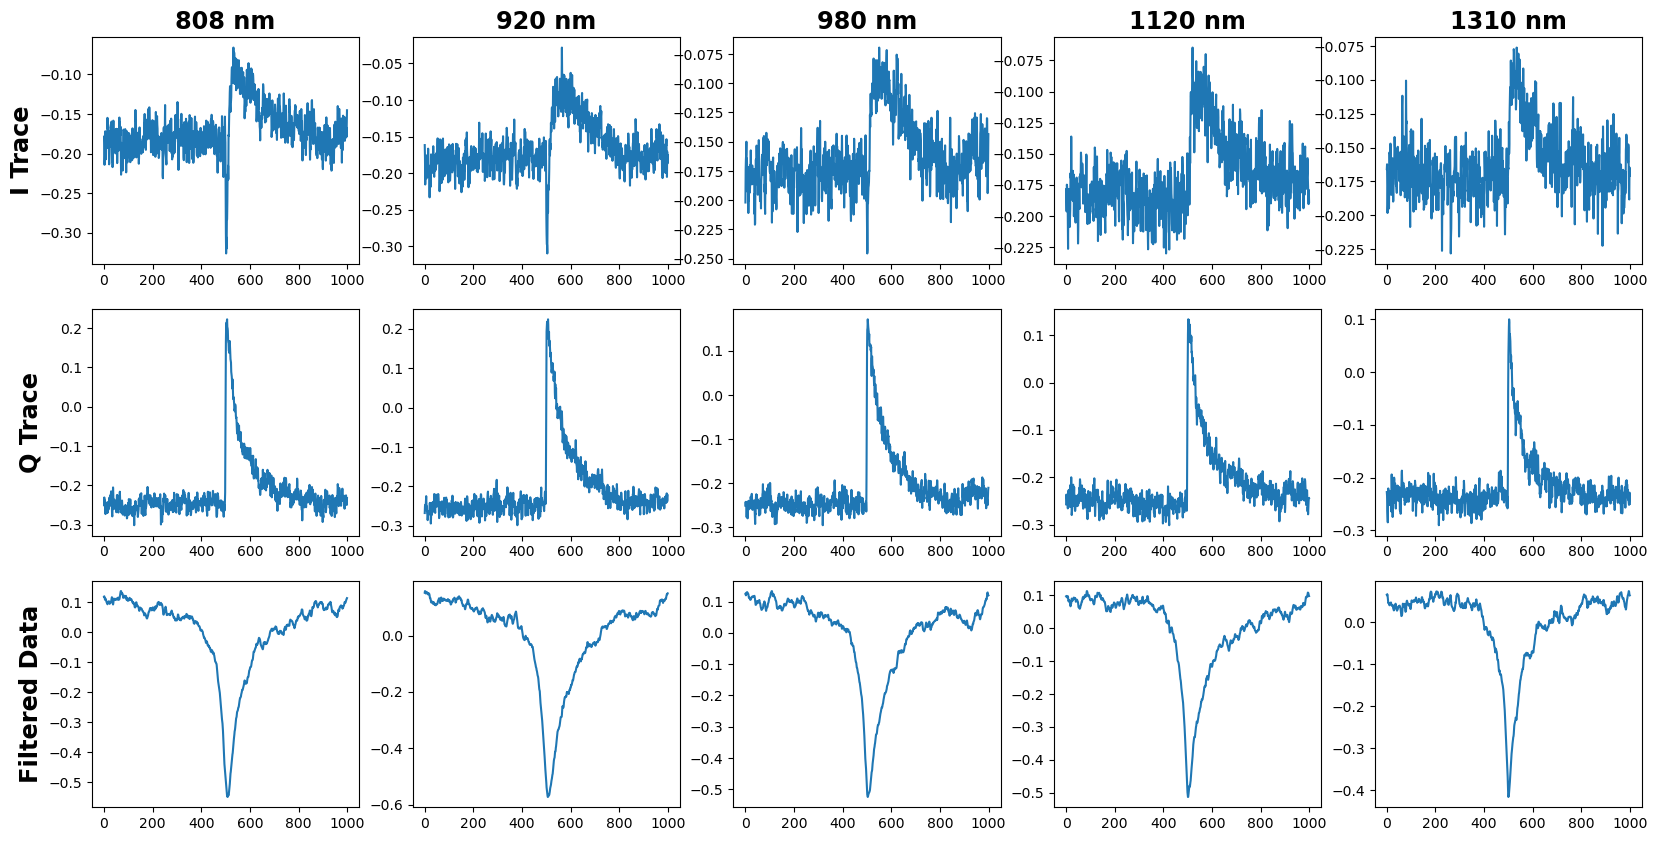

In [3]:
#optimize the comparison for the myriad number of functions in which a comparison like this one is used
@jit(nopython = True)
def comp(i_array, i_val, q_array, q_val):
    comp = (i_array-i_val)*(i_array-i_val) + (q_array - q_val)*(q_array - q_val) #multiplication is faster computationally than exponentiation
    return comp


def mapping(i_trace, q_trace, n_pts):
    #unravel the data to get an array of 50,000 first values, and 50,000 last values
    first_val_i = i_trace[:,:,0].ravel()
    last_val_i = i_trace[:,:,n_pts].ravel()

    first_val_q  = q_trace[:,:,0].ravel()
    last_val_q = q_trace[:,:,n_pts].ravel()
    
    seed_mapping = deque()
    pulse_mapping = deque()
    for i in range(len(first_val_i)):
        comparison = comp(last_val_i, first_val_i[i], last_val_q, first_val_q[i])
        
        index = np.where(comparison == min(comparison)) #now index is a list of number(s) between 0 and 49,999 
        index = np.array(index).ravel() #takes array nestled within list and turns it into a 2d array, then unravels it into a 1D array
        index = int(index[0]) #if multiple indices satisfy the least squares comparison, just pick the first one
        
        seed = index//10000 #determines the seed index(an integer between 0 and 4) from the index through floor division
        pulse = index - seed*10000 #determines the pulse index(an integer between 0 and 9,999) by subtracting previous seed's pulses
        
        seed_mapping.append(seed)
        pulse_mapping.append(pulse)
    
    return seed_mapping, pulse_mapping

#Given a seed and pulse number, returns the index within the mapping array that corresponds to that seed/pulse
@jit(nopython = True)
def index_to_mapping(seed, pulse):
    mapping = seed*10000 + pulse
    return mapping
  


#Plot first pulse in i_trace, q_trace, and filtered_data for each provided wavelength 
t = np.arange(1000) #get time axis in terms of number of points to see what a reasonable estimate for n_pts is
fig, ax = plt.subplots(3,5, figsize = (20,10))
row = ["I Trace","Q Trace","Filtered Data"]
col = ['808 nm','920 nm','980 nm','1120 nm','1310 nm']
for i in range(3):
  ax[i,0].set_ylabel(row[i], rotation = 90, fontweight = "bold", size = 'xx-large')
for i in range(5):
  ax[0,i].plot(t, i_trace[i,0,:])
  ax[1,i].plot(t, q_trace[i,0,:])
  ax[2,i].plot(t, filtered_data[i,0,:])
  ax[0,i].set_title(col[i], fontweight = "bold", size = 'xx-large')

**Generating Mapping**

In [4]:
n_pts = 100
seed_mapping, pulse_mapping = mapping(i_trace, q_trace, n_pts)

Generating the least squares mapping and loading the data takes around ~3 minutes, so it is it's own cell.

**Baselevel Noise Generation** <br>
This cell overwrites the arrays of zero with a noise spectrum generated by stitching together the first `n_pts` of noise from the peak data

In [5]:
#creating base level noise in i_trace, q_trace, and label from pulse data/mapping
pos = 0
pulse = np.random.randint(data_size) #choose a random pulse for a given wavelength
seed = np.random.randint(0,4) #choose a random wavelength of light to include from 5 files
while pos <= N_time_datapoints - n_pts:
    index = index_to_mapping(seed, pulse)
    i_train[pos:pos+n_pts] = i_trace[seed_mapping[index], pulse_mapping[index], 0:n_pts]
    q_train[pos:pos+n_pts] = q_trace[seed_mapping[index], pulse_mapping[index], 0:n_pts]
    pulse = pulse_mapping[index]
    seed = seed_mapping[index]
    pos += n_pts

**Noise and Power Spectral Density Visualization**

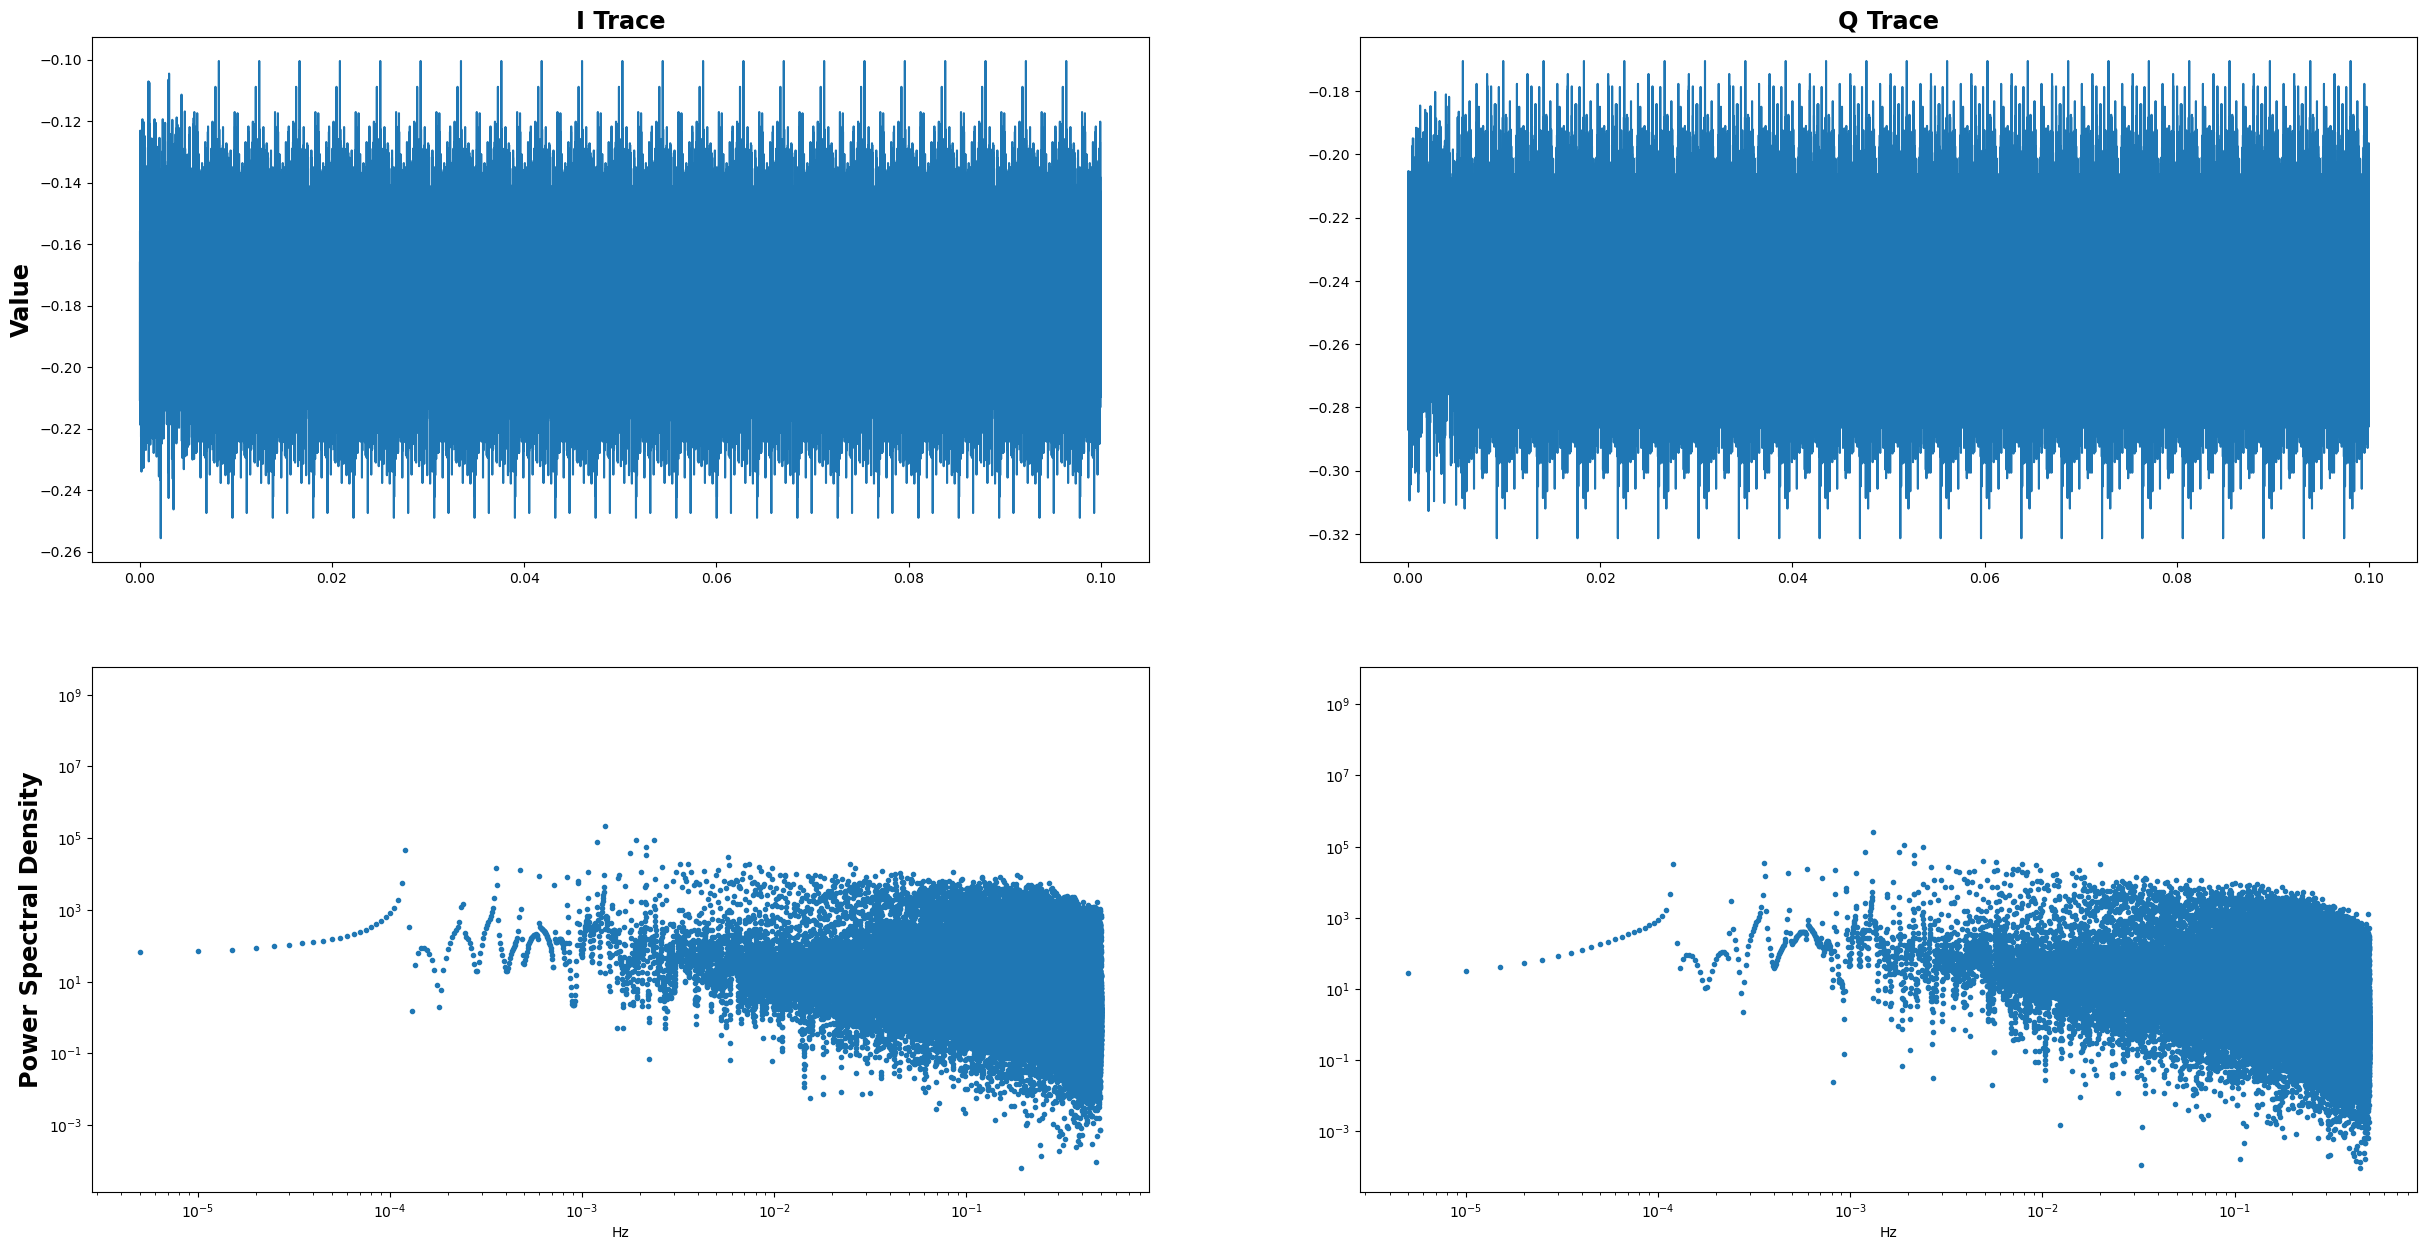

In [6]:
fig, ax = plt.subplots(2,2,figsize = (30,15))

#Fourier Transform stuff
freq = np.fft.fftfreq(len(time))
powerspec_i = np.abs(np.fft.fft(i_train))**2
powerspec_q = np.abs(np.fft.fft(q_train))**2



#Row labels
ax[0,0].set_ylabel("Value",fontweight = "bold",size = 'xx-large', rotation = 90)
ax[1,0].set_ylabel("Power Spectral Density",fontweight = "bold",size = 'xx-large', rotation = 90)

#Column labels
ax[0,0].set_title("I Trace",fontweight = "bold", size = 'xx-large')
ax[0,1].set_title("Q Trace",fontweight = "bold", size = 'xx-large')


#x_label + x_lims
for i in range(2):
  for j in range(2):
    ax[1,j].set_xlabel("Hz")
    #ax[1,j].set_xlim(left=0,right =0.5)
    
    

#I_trace
ax[0,0].plot(time, i_train)
ax[1,0].loglog(freq,powerspec_i,linestyle = '', marker = '.')


#Q_trace
ax[0,1].plot(time, q_train)
ax[1,1].loglog(freq,powerspec_q, linestyle = '', marker = '.')


plt.show()

**Synthetic Data Generation**<br>
This cell redoes the noise generation from earlier, but now at each discrete time step has a probability of `photon_prob` to insert a photon detection.


In [7]:
'''
Function that takes an initial value in i, q, and label and returns the seed and pulse indices of the dataset closest to those initial values
'''
def insert_index(i_insertion_val,q_insertion_val,i_trace,q_trace, peak_indices,halfwidth,insert_peak=bool):
        '''
        Generate first_vals_i, first_vals_q, and first_vals_label if inserting noise
        '''
        if insert_peak == False:
          first_vals_i = i_trace[:,:,0].ravel()
          first_vals_q = q_trace[:,:,0].ravel()
          #generate comparison
          comparison = comp(first_vals_i, i_insertion_val, first_vals_q, q_insertion_val)
          

        '''
        Generate first_vals_i, first_vals_q, and first_vals_label if inserting a peak
        '''
        if insert_peak == True: 
          peak_start_val_i = deque()
          peak_start_val_q = deque()

          #shape(i_trace)[0] is number of wavelengths, shape(i_trace)[1] is number of pulses in a given wavelength dataset
          for i in range(np.shape(i_trace)[0]):  
            for j in range(np.shape(i_trace)[1]):
              val_i = i_trace[i,j,peak_indices[i][j] - halfwidth]
              val_q = q_trace[i,j,peak_indices[i][j] - halfwidth]
              
              peak_start_val_i.append(val_i)
              peak_start_val_q.append(val_q)
          
          peak_start_val_i = np.array(peak_start_val_i)
          peak_start_val_q = np.array(peak_start_val_q)
          
          #generate comparison
          comparison = comp(peak_start_val_i, i_insertion_val, peak_start_val_q, q_insertion_val)

        '''
        Figure out the index that minimizes the generated comparison
        '''
        
        index = np.where(comparison == comparison.min()) #now index is a list of number(s) between 0 and 49,999 
        index = np.array(index).ravel() #takes array nestled within list and turns it into a 2d array, then unravels it into a 1D array

        #if there are multiple indices which satisfy the least squares comparison, select one at random. Ensure index is typecast from tuple to int
        if len(index) > 1:
          choice = np.random.randint(0,len(index))
          index = int(index[choice])
        else:
          index = int(index)
        
        seed = index//10000 #determines the seed index(an integer between 0 and 4) from the index through floor division
        pulse = index - seed*10000 #determines the pulse index(an integer between 0 and 9,999) by subtracting previous seed's pulses

        return seed, pulse


'''
Function that Generates Synthetic Data with or without labels
'''
def synthetic_data_gen(i_trace,q_trace, filtered_data, peak_indices, SampRate, TrainingTime, PhotonRate, n_pts, pulse_halfwidth,return_labels=bool):
    #Uses SampRate, TrainingTime, and PhotonRate to generate N_time_datapoints and photon_prob
    N_time_datapoints = int(SampRate*TrainingTime) #Number of datapoints based on the training time and sample rate
    photon_prob = PhotonRate/SampRate #The probability that a photon is incident at a given time_datapoint

    
    #Initializing arrays to return
    photon_energy = np.zeros(N_time_datapoints)
    prob_incident = np.zeros(N_time_datapoints)
    i_train = np.zeros(N_time_datapoints)
    q_train = np.zeros(N_time_datapoints)

    #randomly initializing pulse and seed
    pos = 0
    pulse = np.random.randint(data_size) #choose a random pulse for a given wavelength
    seed = np.random.randint(0,4) #choose a random wavelength of light to include from 5 files
    while pos <= N_time_datapoints - n_pts:
        #If not inserting peak, continue stitching together noise
        index = index_to_mapping(seed, pulse)
        i_train[pos:pos+n_pts] = i_trace[seed_mapping[index], pulse_mapping[index], 0:n_pts]
        q_train[pos:pos+n_pts] = q_trace[seed_mapping[index], pulse_mapping[index], 0:n_pts]
        photon_energy[pos:pos+n_pts] = filtered_data[seed_mapping[index], pulse_mapping[index], 0:n_pts]
        pulse = pulse_mapping[index]
        seed = seed_mapping[index]
        pos += n_pts
        
        #Generates a random number drawn from a uniform distribution over [0,1) and if it's less than or equal to the probability, insert a peak. It also ensures there is enough space left in the generated data to insert a pulse 
        if np.random.rand() <= photon_prob*n_pts and pos <= N_time_datapoints - pulse_halfwidth*2: 
            #finding insertion values
            i_insertion_val = i_train[pos-1]
            q_insertion_val = q_train[pos-1]
    
            #finding seed and pulse insert index for peak insertion
            peak_seed, peak_pulse = insert_index(i_insertion_val, q_insertion_val, i_trace, q_trace, peak_indices, pulse_halfwidth, insert_peak = True)

            #Error checking to ensure pulse is sufficiently centered to grab a full halfwidth on either side of it. If it fails this check, returns to the beginning of the loop and does not place a pulse
            pmax = peak_indices[peak_seed][peak_pulse]
            if pmax < pulse_halfwidth or pmax > np.shape(i_trace)[2] - pulse_halfwidth:
                continue

            #inserting peak
            i_train[pos:pos+pulse_halfwidth*2] = i_trace[peak_seed, peak_pulse, pmax-pulse_halfwidth:pmax + pulse_halfwidth]
            q_train[pos:pos+pulse_halfwidth*2] = q_trace[peak_seed, peak_pulse, pmax-pulse_halfwidth:pmax + pulse_halfwidth]
            photon_energy[pos:pos+pulse_halfwidth*2] = filtered_data[peak_seed, peak_pulse, pmax-pulse_halfwidth:pmax + pulse_halfwidth] 
            prob_incident[pos+pulse_halfwidth] = 1
            pos += pulse_halfwidth*2

            #function parameters for inserting data on the other side of the peak
            i_insertion_val = i_train[pos-1]
            q_insertion_val = q_train[pos-1]

            #find seed and pulse with smallest discontinuity on the peak's tail for insertion of subsequent data
            seed, pulse = insert_index(i_insertion_val, q_insertion_val, i_trace, q_trace, peak_indices, pulse_halfwidth, insert_peak = False)

            continue

    if return_labels == True:
        label = prob_incident, photon_energy
        return i_train, q_train, label
    elif return_labels == False:
        return i_train, q_train

'''
Generating Synthetic Data Using the Functions defined above
'''
#generating training data for display
pulse_halfwidth = 400
i_train, q_train, label = synthetic_data_gen(i_trace,q_trace, filtered_data, peak_indices, SampRate, TrainingTime, PhotonRate, n_pts, pulse_halfwidth,return_labels=True)



**Synthetic Data and Power Spectral Density Visualization**

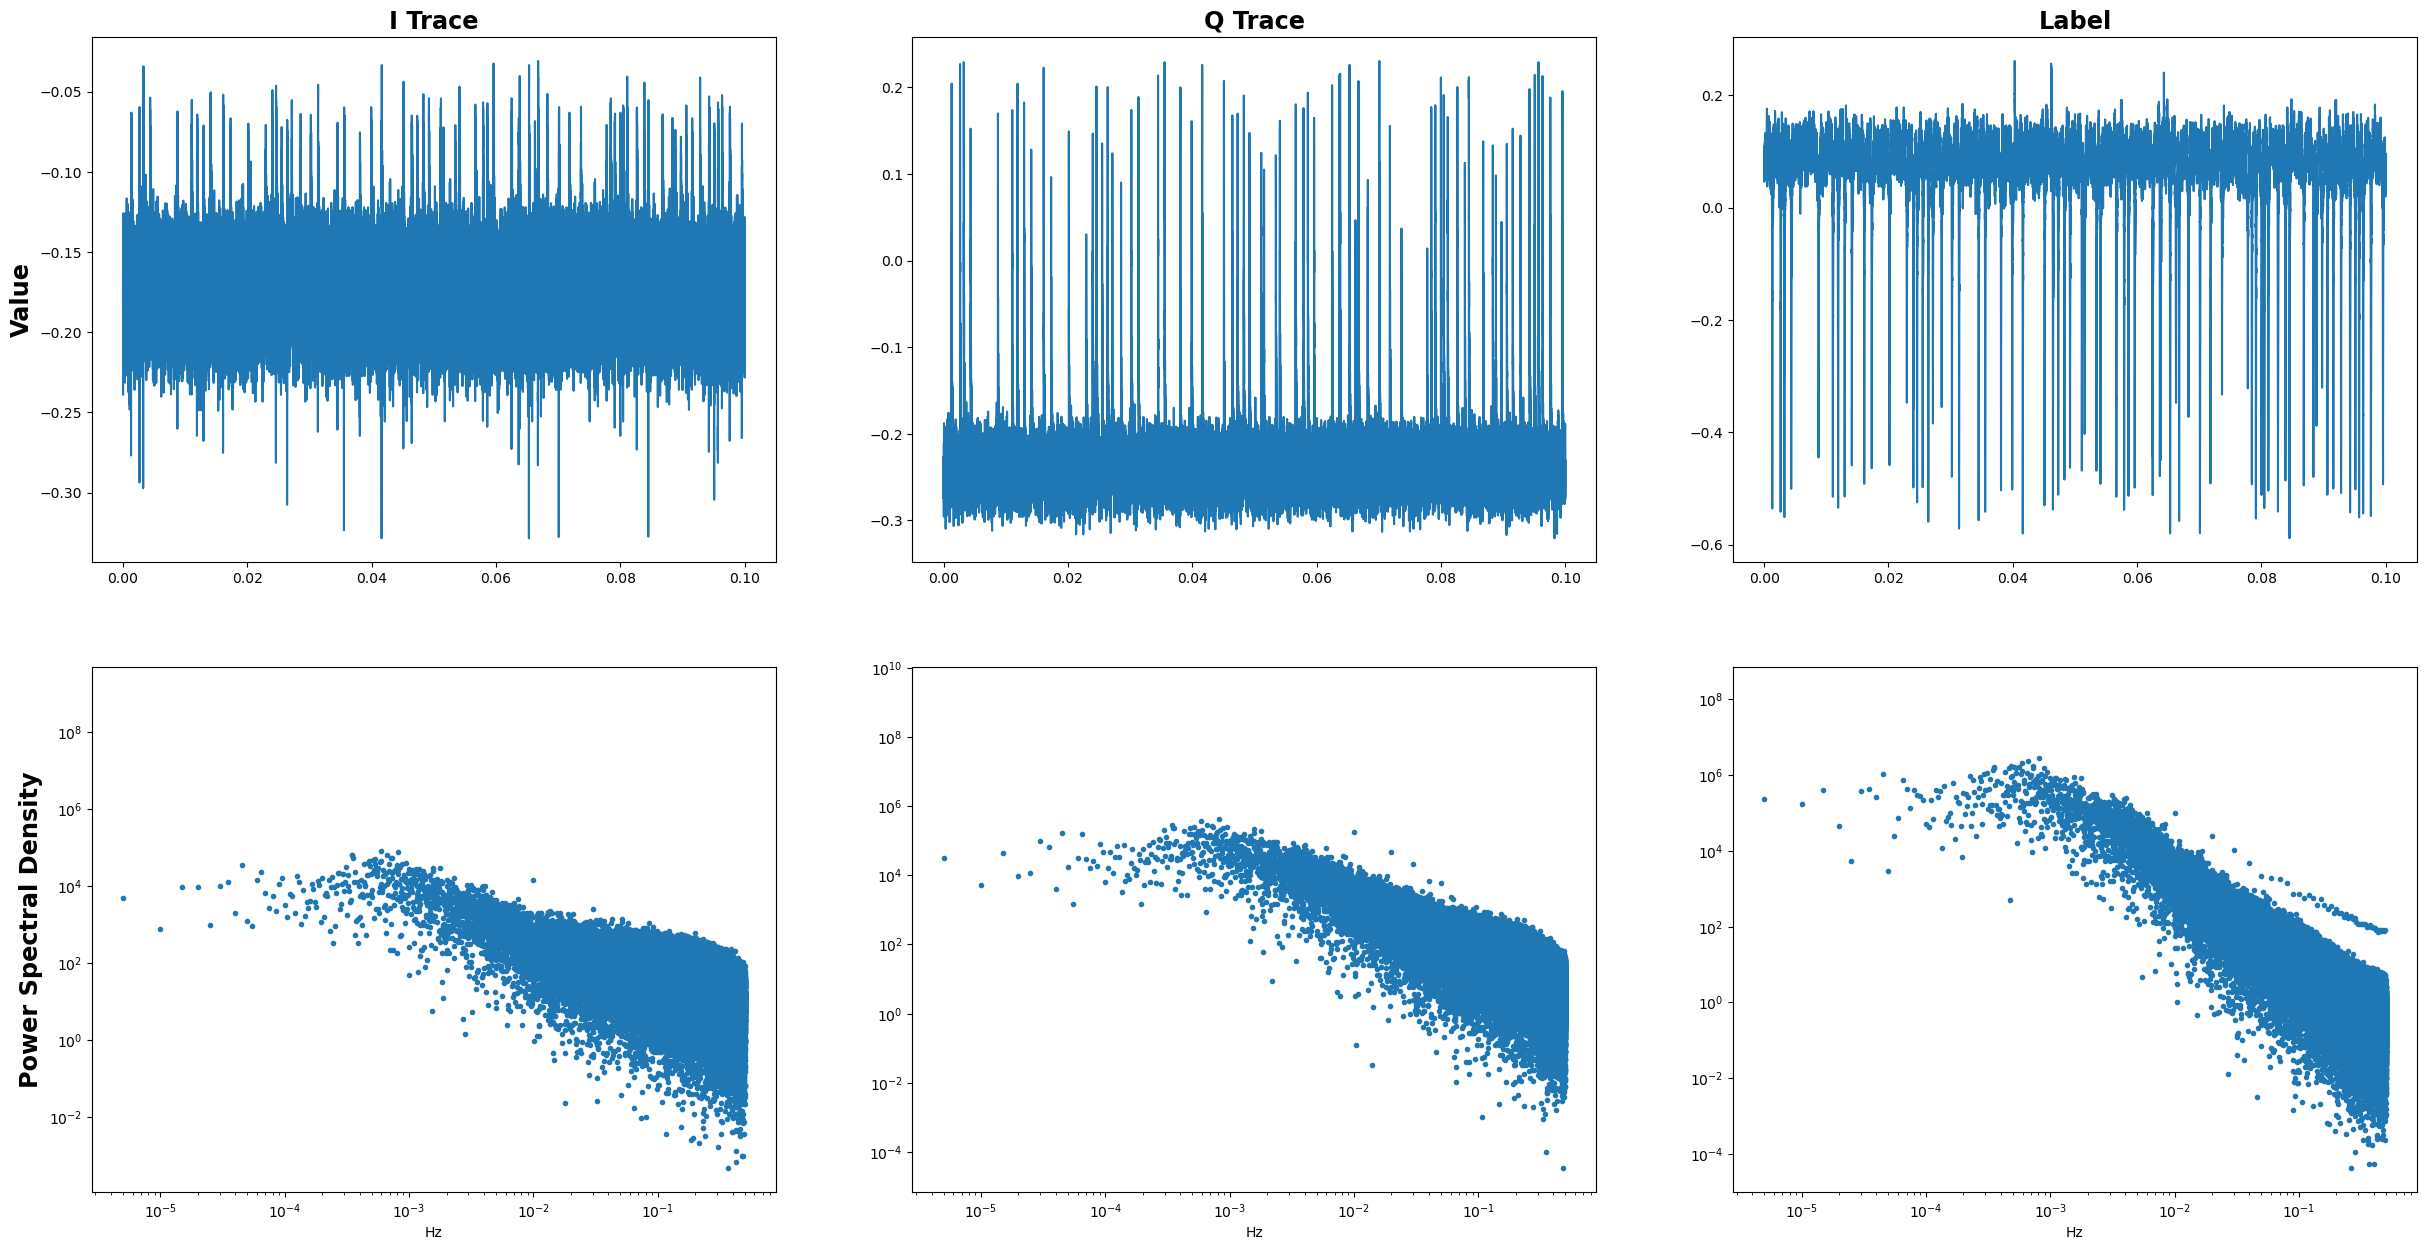

In [8]:
fig, ax = plt.subplots(2,3,figsize = (30,15))

photon_prob, photon_energy = label

#Fourier Transform stuff
freq = np.fft.fftfreq(len(time))
powerspec_i = np.abs(np.fft.fft(i_train))**2
powerspec_q = np.abs(np.fft.fft(q_train))**2
powerspec_label = np.abs(np.fft.fft(photon_energy))**2


#Row labels
ax[0,0].set_ylabel("Value",fontweight = "bold",size = 'xx-large', rotation = 90)
ax[1,0].set_ylabel("Power Spectral Density",fontweight = "bold",size = 'xx-large', rotation = 90)

#Column labels
ax[0,0].set_title("I Trace",fontweight = "bold", size = 'xx-large')
ax[0,1].set_title("Q Trace",fontweight = "bold", size = 'xx-large')
ax[0,2].set_title("Label",fontweight = "bold", size = 'xx-large')

#x_label + x_lims
for j in range(3):
    ax[1,j].set_xlabel("Hz")

#I_trace
ax[0,0].plot(time, i_train)
ax[1,0].loglog(freq,powerspec_i, linestyle = '', marker = '.')

#Q_trace
ax[0,1].plot(time, q_train)
ax[1,1].loglog(freq,powerspec_q, linestyle = '', marker = '.')

#Photon Energy
ax[0,2].plot(time,photon_energy)
ax[1,2].loglog(freq,powerspec_label, linestyle = '', marker = '.') #I don't think there's any physical meaning to be pulled from this plot

plt.show()

If there are no photons incident in the validation set (the last `1-split_fraction` datapoints in the dataset) then the early stopping callback may halt training early because validation loss isn't improving. To solve this problem, either increase `TrainingTime` so that the validation set will always contain incident photons - at the expense of computational time in training the model, or rerun the **Synthetic Generation** and **Synthetic Data and Power Spectral Density Visualization** cells to regenerate synthetic training data until the validation dataset contains incident photons.

# **Model Loading**

**Hyperparameters** <br>
Port hyperparameters used in training the model

In [9]:
num_past_time_steps = 50 #This hyperparameter describes how many datapoints into the past the model will look at when making predictions
num_future_time_steps = 100 #This hyperparameter describes how many datapoints into the future the model will look at when making predictions
batch_size = 100 #This hyperparameter describes how many Dataset slices the model will look at before adjusting model parameters
vector_size = 2 #this indicates the dimension of inputs to the model (currently dimensions of [I, Q])

**Loading Model**

In [10]:
model = tf.keras.models.load_model("saved_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 128)            96768     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 128)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             41024     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 32)             10272     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 32)            0

**Displaying Training Metrics**

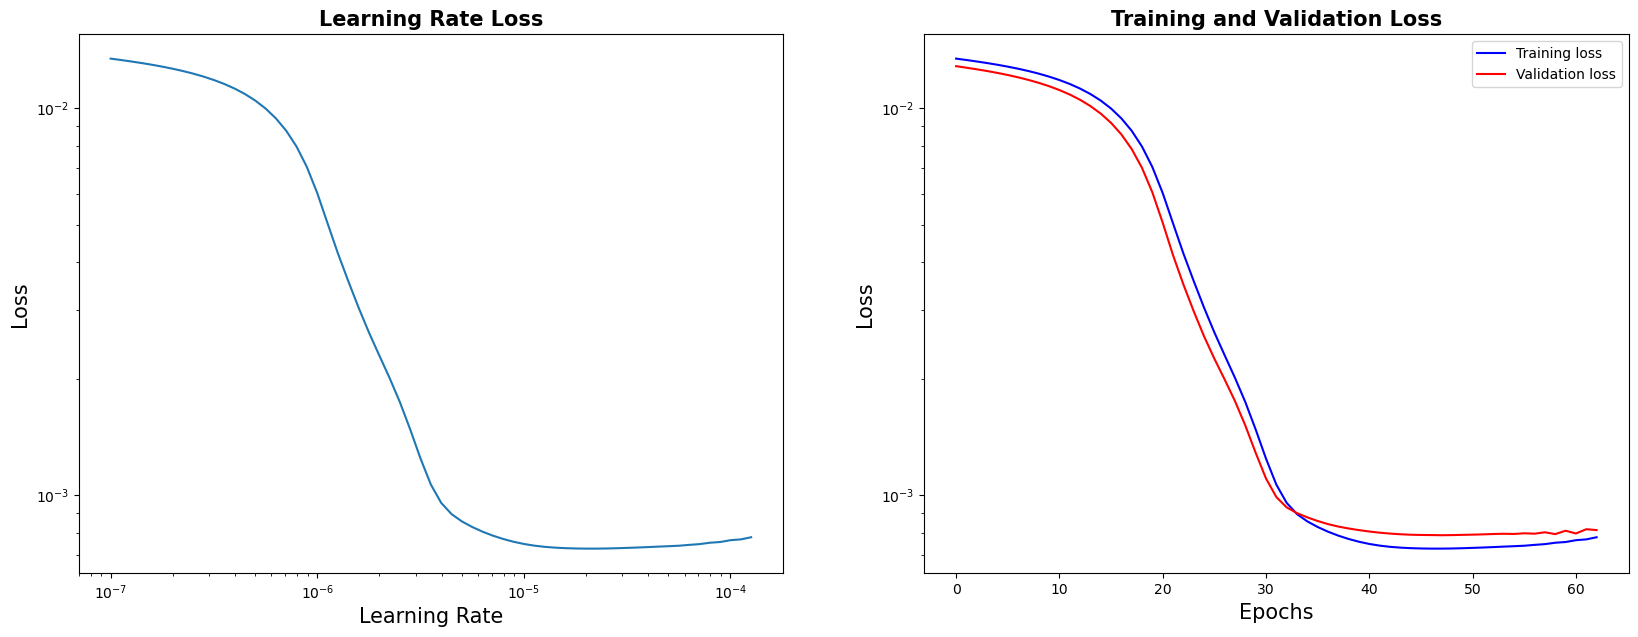

In [11]:
history = np.load("my_history.npy", allow_pickle = True).item()
fig, ax = plt.subplots(1,2, figsize = (20,7))


#display Loss as a function of Learning Rate
ax[0].loglog(history["lr"], history["loss"])
ax[0].set_xlabel("Learning Rate", fontsize = 15)
ax[0].set_title("Learning Rate Loss", fontsize = 15, fontweight = 'bold')
ax[0].set_ylabel("Loss", fontsize = 15)


#Display Loss as a function of epochs
loss = history["loss"]
val_loss = history["val_loss"]
epochs = range(len(loss))
ax[1].semilogy(epochs, loss, c="b", label="Training loss")
ax[1].semilogy(epochs, val_loss,c="r", label="Validation loss")
ax[1].set_title("Training and Validation Loss", fontsize = 15, fontweight = 'bold')
ax[1].set_xlabel("Epochs", fontsize = 15)
ax[1].set_ylabel("Loss", fontsize = 15)
ax[1].legend()
plt.show()

# **Model Evaluation**

**Defining Data Processing Functions** <br>
For consistency,  we need to create the evaluation data the same way we create the training data, which means we must redefine the functions utilized to process synthetic data in the old notebook

In [12]:
def normalize(data):
  mean = np.mean(data)
  std = np.std(data)
  return (data-mean)/(std)

def make_windows(input_array, num_prev_time_steps, num_future_time_steps):
    #identifying the span of each window in terms of given parameters
    span = num_prev_time_steps + 1 + num_future_time_steps #the +1 is for the present time step for which the window is centered around
    input_array = np.float32(input_array)
    
    #if input_array is 1D
    if len(input_array.shape) == 1:
        #getting parameters from the shape of the input array
        length = len(input_array)
        num_windows = length - (span - 1) #the -1 is to account for the present time step for which the window is centered around

        #initializing windows with correct shape
        windows = np.zeros(shape = (span, num_windows))
    
        #filling windows with values from the array
        for i in range(num_windows):
            windows[:,i] = input_array[i:span+i]
    
    #otherwise (which really just means 2D because this isn't able to compensate for 3D or higher input_arrays)
    else:
        #getting parameters from the shape of the input array
        length, height = input_array.shape
        num_windows = length - (span - 1) #the -1 is to account for the present time step for which the window is centered around
    
        #initializing windows with correct shape
        windows = np.zeros(shape = (span, height, num_windows))
    
        #filling windows with values from the array
        for i in range(num_windows):
            windows[:,:,i] = input_array[i:span+i]
    
    #Dataset_from_tensor_slices consumes the first dimension, so we should transpose the windows so the first axis is the axis of windows
    windows = np.transpose(windows)
  
    return windows


def make_Dataset(batch_size, num_prev_time_steps, num_future_time_steps, I, Q, label = None):
    #only normalize the input data so the target output doesn't get warped
    I = normalize(I)
    Q = normalize(Q)

    #creating array from which to make windows
    input_data = np.zeros(shape=(I.size,2))
    input_data[:,0] = I
    input_data[:,1] = Q

    #creating windows for the data
    window = make_windows(input_data, num_prev_time_steps, num_future_time_steps)
    data_windows = tf.convert_to_tensor(window, dtype = tf.float32)

    #using optional argument to build Datasets with/without labels & time if they are/aren't passed
    if label is None:
        dataset = tf.data.Dataset.from_tensor_slices(data_windows)
    else:
        #converting label to tensor
        energy_label = tf.convert_to_tensor(label[1][num_prev_time_steps:-num_future_time_steps], dtype = tf.float32)

        #constructing dataset tuple
        dataset = tf.data.Dataset.from_tensor_slices((data_windows, energy_label))
    
    #batching datasets
    batched_dataset = dataset.batch(batch_size)

    return batched_dataset

**Defining `model_predictions` Function**<br>
The `model_predictions` function generates evaluation data using the `synthetic_data_gen` function defined under the **Data Generation** heading. It then generates and returns model predictions based on the evaluation data generated in the function call. 

In [13]:
def model_predictions(model, i_trace,q_trace, filtered_data, peak_indices, SampRate, TrainingTime, PhotonRate, n_pts, pulse_halfwidth, return_labels = bool):
    #generating evaluation data
    i_eval, q_eval, label_eval = synthetic_data_gen(i_trace, q_trace, filtered_data, peak_indices, SampRate, TrainingTime, PhotonRate, n_pts, pulse_halfwidth,return_labels=True)
    N_time_datapoints = int(SampRate*TrainingTime)

    #Need to create the evaluation data the same way as the training data, using previously defined functions
    dataset_eval = make_Dataset(batch_size, num_past_time_steps, num_future_time_steps, i_eval, q_eval, None)

    #Generating Model Predictions
    output = model.predict(dataset_eval)

    #the 1 dimensional model prediction is at each index the predicted energy of a photon multiplied by the probability that there is indeed a photon incident
    model_prediction = np.squeeze(output)

    if return_labels == True:
        return model_prediction, label_eval
    elif return_labels == False:
        return model_prediction        

**Generating a Rescaling Factor**<br>
Model predictions need to be rescaled by a constant factor in order to be compared to label peaks. This `rescaling_factor` can be estimated by eye, but ideally, we want to determine the rescaling factor quantitatively for any set of data that the model might be asked to make predictions upon. In the next code cell, we generate evaluation data and minimize the `scaling_factor` function(which returns the least squares difference between the model's predicted peaks and the label's peaks) to obtain the best fit `rescaling_factor`. We then perform bootstrap resampling by redoing the previous step multiple times in order to recover a bootstrapped `rescaling_factor` and it's uncertainty. This bootstrapped resampled `rescaling_factor` can then be applied to all predictions made by the model. Expect this cell to take around 10 minutes to run with 50 iterations.

In [14]:
temporal_shift_range = 250 #The number of values on either side of label peaks we will look for a temporally shifted peak

#Defining the function to minimize to obtain the scaling factor for each generated evaluation dataset
def scaling_factor(rescaling_factor, model_prediction, label_eval):
    #when the label does not equal zero, a photon is incident
    prob_eval, energy_eval = label_eval
    peak_indices = np.squeeze(np.asarray(np.where(prob_eval != 0)))
    lstsq = 0

    #We want to determine the appropriate scaling factor by minimizing the least squares difference of the model predictions and label values for photon energy
    for peak in peak_indices:
        label_peak = energy_eval[peak]
        prediction_range = model_prediction[peak - temporal_shift_range: peak + temporal_shift_range]
        model_peak = min(prediction_range) #pick the minimum value in the prediction because that's where the 
        lstsq += (model_peak*rescaling_factor - label_peak)**2 #calculate lstsq value(to be minimized)

    return lstsq

#Passing the scaling_factor function to the minimizing function
def find_best_rescaling_factor(model_prediction, label_eval):
    guess = np.random.rand() #Since we are only fitting one parameter, our initial guess shouldn't matter
    rescaling_factor = minimize(scaling_factor, guess, args=(model_prediction, label_eval), method = "Powell").x
    return rescaling_factor

#Defining the function to minimize to obtain the temporal shift factor for each generated evaluation dataset
def find_best_temporal_shift(model_prediction, label_eval):
    #when the label does not equal zero, a photon is incident
    prob_eval, energy_eval = label_eval
    peak_indices = np.squeeze(np.asarray(np.where(prob_eval != 0)))
    temporal_shift = []

    #We want to determine the appropriate temporal shift by averaging all the temporal shifts over the entire model
    for peak in peak_indices:
        label_peak = energy_eval[peak]
        prediction_range = model_prediction[peak - temporal_shift_range: peak + temporal_shift_range]
        temporal_shift.append(np.squeeze(np.asarray(np.where(prediction_range == min(prediction_range)))) - len(prediction_range)/2)

    #calculating statistics
    temporal_shift = np.asarray(temporal_shift)
    avg_temporal_shift = np.mean(temporal_shift)
    sigma_temporal_shift = np.std(temporal_shift)

    return avg_temporal_shift, sigma_temporal_shift

eval_TrainingTime = 0.015 #even if training the model on more than 0.015 second of training time, evaluate it on 0.015 second of traing time because it's faster
N_time_datapoints = int(SampRate*eval_TrainingTime)
time_eval = np.linspace(0,TrainingTime,N_time_datapoints)

#Performing bootstrap resampling: When generating synthetic data with a training time of 0.01 seconds, model_predictions took about 10 seconds per iteration(expect this cell to be computationally expensive)
num_iter = 50
bstrap_rescaling_list = deque()
bstrap_temporal_avg_list = deque()
bstrap_temporal_sigma_list = deque()
for i in range(num_iter):
    bstrap_model_prediction, bstrap_label = model_predictions(model, i_trace,q_trace, filtered_data, peak_indices, SampRate, eval_TrainingTime, PhotonRate, n_pts, pulse_halfwidth, return_labels = True)
    
    #bstrapping rescaling factor
    rescaling_factor_i = find_best_rescaling_factor(bstrap_model_prediction, bstrap_label)
    bstrap_rescaling_list.append(rescaling_factor_i)

    #bstrapping temporal shift
    avg_temporal_shift_i, sigma_temporal_shift_i  = find_best_temporal_shift(bstrap_model_prediction, bstrap_label)
    bstrap_temporal_avg_list.append(avg_temporal_shift_i)
    bstrap_temporal_sigma_list.append(sigma_temporal_shift_i)

#Rescaling Factor
bstrap_rescaling_factor = np.mean(bstrap_rescaling_list)
sigma_rescaling_factor = np.std(bstrap_rescaling_list)
print(f"Using bootstrap resampling with {num_iter} iterations generates a rescaling factor of {bstrap_rescaling_factor:.3f} ± {sigma_rescaling_factor:.3f}")

#Temporal Shift
bstrap_temporal_shift = np.mean(bstrap_temporal_avg_list)
sigma_temporal_shift = np.mean(bstrap_temporal_sigma_list)
print(f"Using bootstrap resampling with {num_iter} iterations generates a temporal shift of {bstrap_temporal_shift:.3f} ± {sigma_temporal_shift:.3f}")

299/299 [==============================] - 2s 8ms/step
Using bootstrap resampling with 50 iterations generates a rescaling factor of 0.939 ± 0.049
Using bootstrap resampling with 50 iterations generates a temporal shift of -49.569 ± 2.196


A small range of rescaling factors from multiple iterations of model predictions on randomly created evaluation data during bootstrapping implies that the model is consistently 'off' the true values by roughly the same amount. This corresponds to the uncertainty on the bootstrap resampled rescaling factor, which therefore gives an indication of how precise (and therefore how good) the model is.

**Model Prediction + Scaling Factor Generation**

In [75]:
prediction, label_eval = model_predictions(model, i_trace,q_trace, filtered_data, peak_indices, SampRate, eval_TrainingTime, PhotonRate, n_pts, pulse_halfwidth, return_labels = True)
best_rescaling_factor = find_best_rescaling_factor(prediction, label_eval)
prob_eval, energy_eval = label_eval

299/299 [==============================] - 3s 9ms/step


**Prediction Visualization**

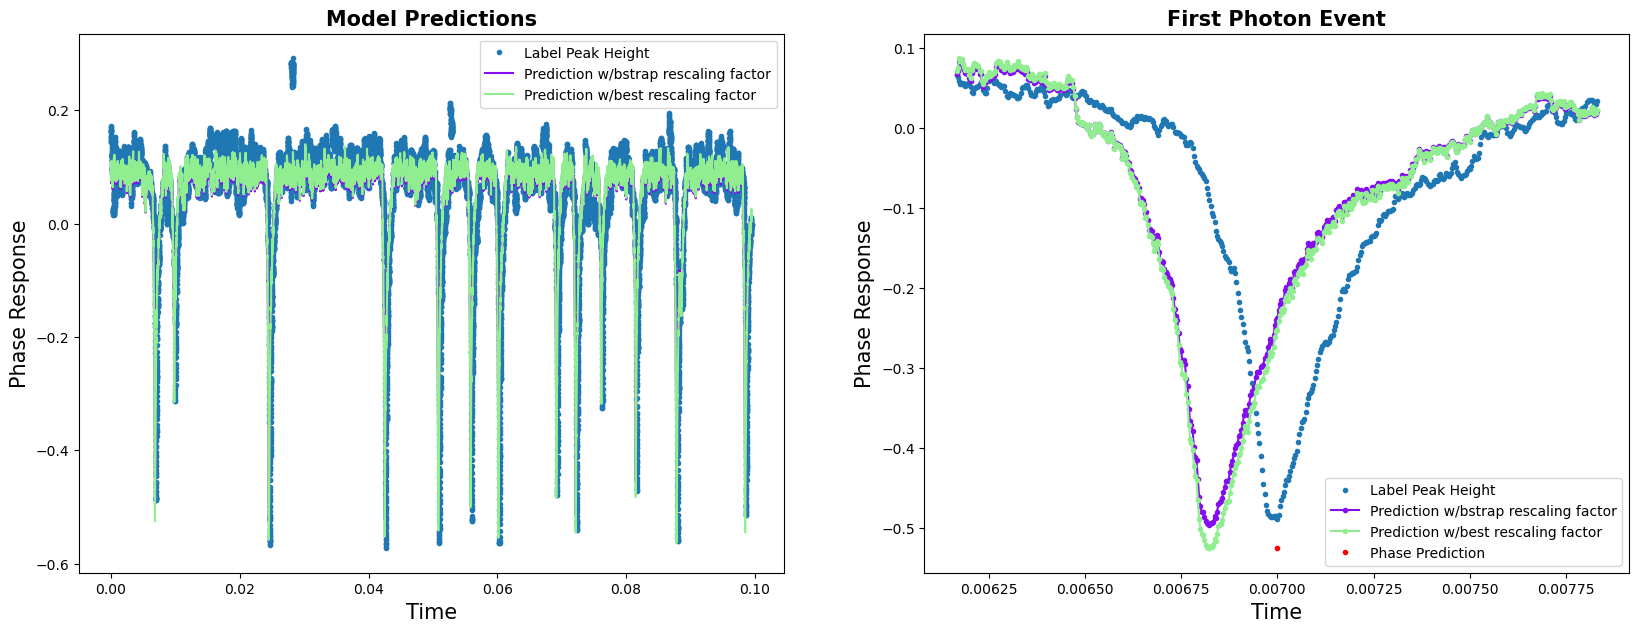

In [76]:
fig, ax = plt.subplots(1,2, figsize = (20,7))

#Plotting Model Predictions
ax[0].plot(time_eval[0:N_time_datapoints - (num_future_time_steps + num_past_time_steps)],energy_eval[0:N_time_datapoints - (num_future_time_steps + num_past_time_steps)],label = "Label Peak Height", linestyle = '', marker= '.')
ax[0].plot(time_eval[0:N_time_datapoints - (num_future_time_steps + num_past_time_steps)],prediction[0:N_time_datapoints - (num_future_time_steps + num_past_time_steps)]*bstrap_rescaling_factor,label = "Prediction w/bstrap rescaling factor", c = '#850ef0')
ax[0].plot(time_eval[0:N_time_datapoints - (num_future_time_steps + num_past_time_steps)],prediction[0:N_time_datapoints - (num_future_time_steps + num_past_time_steps)]*best_rescaling_factor,label = "Prediction w/best rescaling factor", c = 'lightgreen')
ax[0].set_ylabel("Phase Response", fontsize = 15)
ax[0].set_xlabel("Time", fontsize = 15)
ax[0].set_title("Model Predictions", fontweight = 'bold', fontsize = 15)
ax[0].legend(loc = 'upper right')

#Zooming in on the first Photon Detection
first_photon = np.squeeze(np.asarray(np.where(prob_eval != 0)))[0] #gets index of first photon detection
nearest_peak = min(prediction[first_photon - temporal_shift_range: first_photon + temporal_shift_range]) #gets value of the nearest peak
ax[1].plot(time_eval[first_photon - temporal_shift_range:first_photon + temporal_shift_range],energy_eval[first_photon - temporal_shift_range:first_photon + temporal_shift_range],label = "Label Peak Height", linestyle = '', marker= '.')
ax[1].plot(time_eval[first_photon - temporal_shift_range:first_photon + temporal_shift_range],prediction[first_photon - temporal_shift_range:first_photon + temporal_shift_range]*bstrap_rescaling_factor,marker = '.',label = "Prediction w/bstrap rescaling factor",c = '#850ef0')
ax[1].plot(time_eval[first_photon - temporal_shift_range:first_photon + temporal_shift_range],prediction[first_photon - temporal_shift_range:first_photon + temporal_shift_range]*best_rescaling_factor,marker = '.',label = "Prediction w/best rescaling factor", c = 'lightgreen')
ax[1].plot(time_eval[first_photon], nearest_peak*best_rescaling_factor, label = "Phase Prediction", linestyle = '', marker = '.', color = 'red')
ax[1].set_ylabel("Phase Response", fontsize = 15)
ax[1].set_xlabel("Time", fontsize = 15)
ax[1].set_title("First Photon Event", fontweight = 'bold', fontsize = 15)
ax[1].legend()

plt.show()


**Energy Histogram Data Generation** <br>
Comparing the histogram of energies from the label to the predictions. If they are indistinguishable, it implies that the machine learning model is an appropriate tool for data analysis for this system.

In [30]:
def gen_hist_data (TrainingTime):
    #For reasons I don't fully understand, joblib struggles with naming conflicts if you make function calls to other functions that have objects with identical names (or something)
    #After a lot of trial and error but mostly error, I took the contents of the model_predictions function (defined above), and copy + pasted it here. It works. Don't question it.
    i_eval, q_eval, label_eval = synthetic_data_gen(i_trace, q_trace, filtered_data, peak_indices, SampRate, TrainingTime, PhotonRate, n_pts, pulse_halfwidth,return_labels=True)
    N_time_datapoints = int(SampRate*TrainingTime)

    #Need to create the evaluation data the same way as the training data, using previously defined functions
    dataset_eval = make_Dataset(batch_size, num_past_time_steps, num_future_time_steps, i_eval, q_eval, None)

    #Generating Model Predictions
    model = tf.keras.models.load_model("saved_model.h5") #I also have to load the model explicitly in this function or joblib freaks out. Why? No clue. 
    output = model.predict(dataset_eval)

    #the 1 dimensional model prediction is at each index the predicted energy of a photon multiplied by the probability that there is indeed a photon incident
    prediction = np.squeeze(output)

    #####################################################################
    #everything above this comment is from the model_predictions function
    true_prob, true_energy = label_eval

    #acquiring peak values for the label
    index = np.where(true_prob == 1)
    true_peaks = np.asarray(true_energy[index]) 

    #acquiring peak values for the prediction
    prediction = prediction*bstrap_rescaling_factor
    pred_indices, min = find_peaks(-1*prediction,height = 0.2 ,distance = temporal_shift_range) #multiplied by negative one to find minima instead of maxima
    pred_peaks = np.asarray(-1*min['peak_heights']) #find_peaks creates an array with peak_indices and a dictionary with peak_heights as a key

    return true_peaks, pred_peaks

#Multiprocessing
multi = Parallel(n_jobs = -1, verbose = 10)(delayed(gen_hist_data)(0.5) for i in range(32))

#unpacking values
true_peaks_hist = []
pred_peaks_hist = []
for process in multi:
    true_peaks, pred_peaks = process
    true_peaks_hist.extend(true_peaks)
    pred_peaks_hist.extend(pred_peaks)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done  21 out of  32 | elapsed: 33.1min remaining: 17.3min
[Parallel(n_jobs=-1)]: Done  25 out of  32 | elapsed: 40.5min remaining: 11.3min
[Parallel(n_jobs=-1)]: Done  29 out of  32 | elapsed: 42.4min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed: 43.1min finished


**Visualizing Histograms**

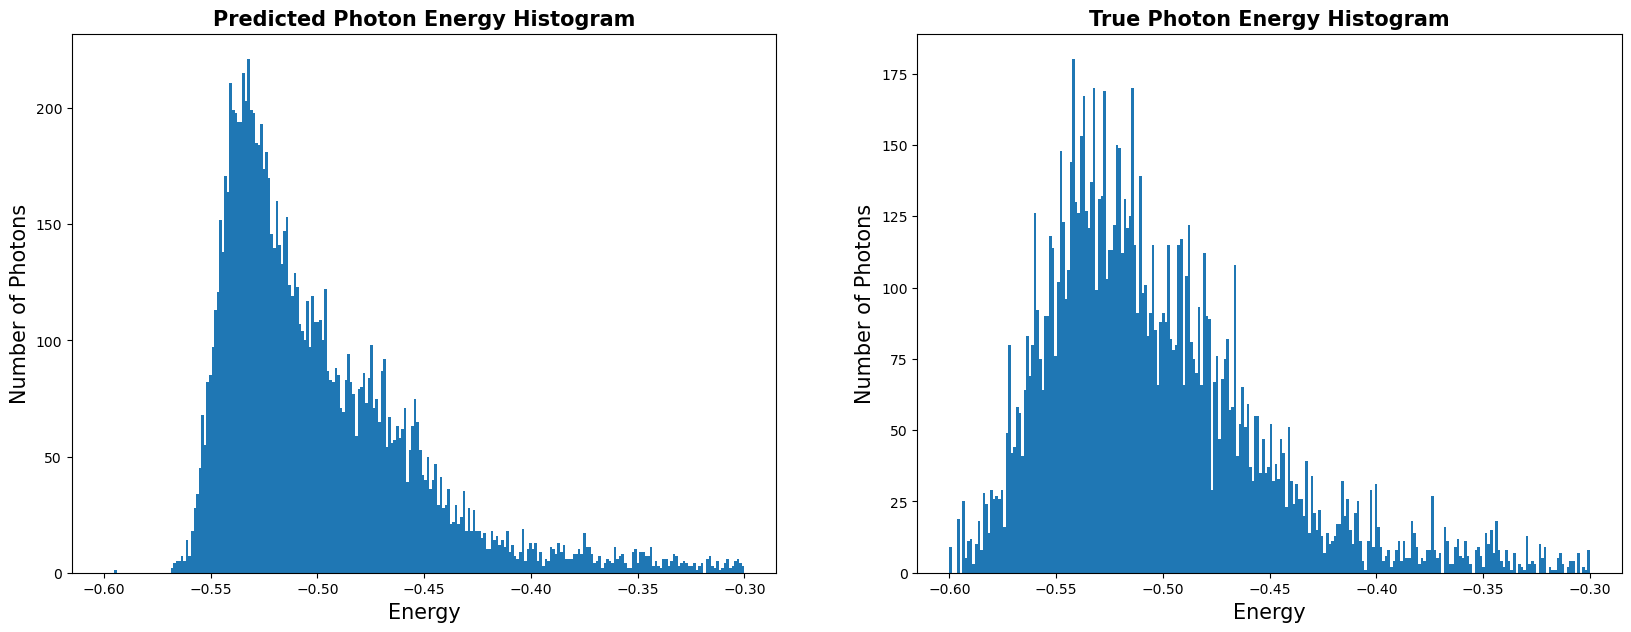

In [32]:
#Plotting Histograms
fig, ax = plt.subplots(1,2, figsize = (20,7))
ax[0].hist(pred_peaks_hist,bins = 250, range = (-0.6,-0.3))
ax[0].set_ylabel("Number of Photons", fontsize = 15)
ax[0].set_xlabel("Energy", fontsize = 15)
ax[0].set_title("Predicted Photon Energy Histogram", fontweight = 'bold', fontsize = 15)

ax[1].hist(true_peaks_hist,bins = 250, range = (-0.6,-0.3))
ax[1].set_ylabel("Number of Photons", fontsize = 15)
ax[1].set_xlabel("Energy", fontsize = 15)
ax[1].set_title("True Photon Energy Histogram", fontweight = 'bold', fontsize = 15)

plt.show()

**Histogram for Full Spectra**

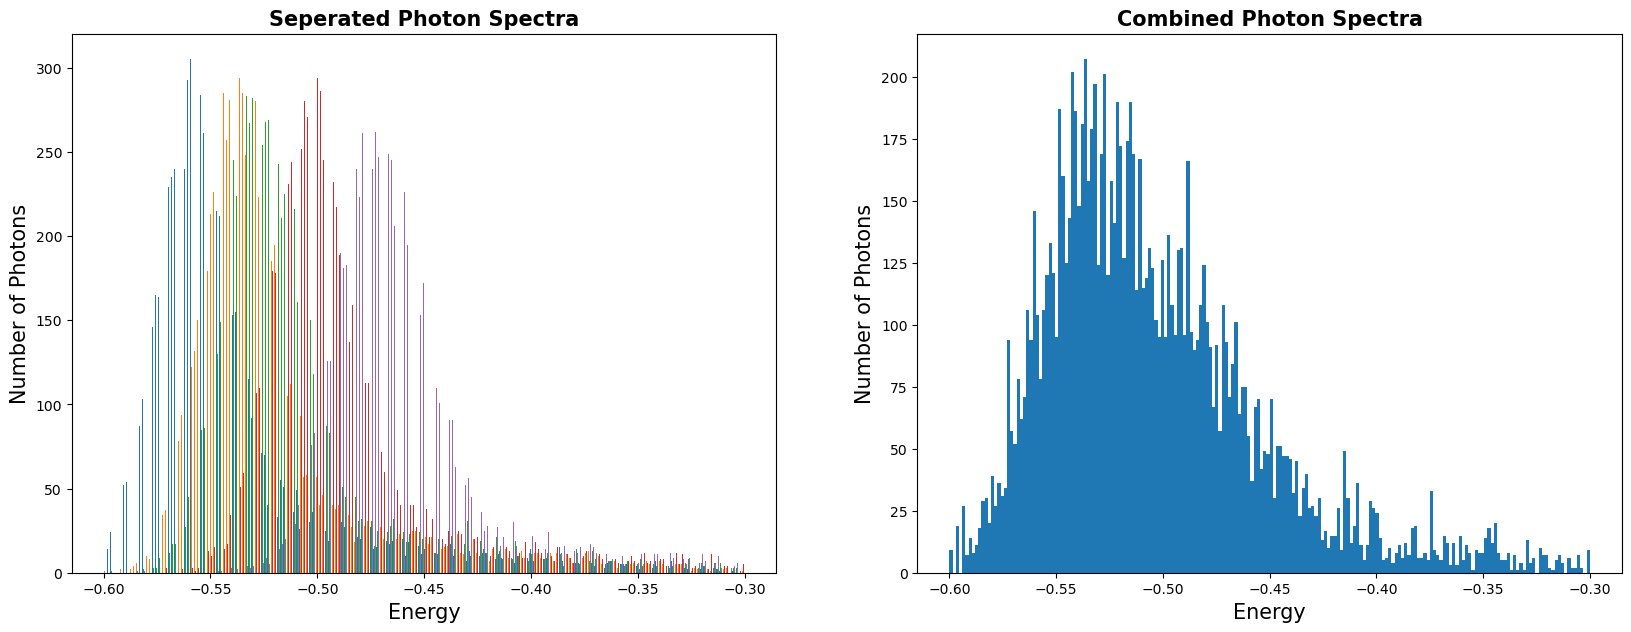

In [57]:
sep_spectra = peak_heights
comb_spectra = []
for spectra in peak_heights:
    comb_spectra.extend(spectra)

#Plotting Histograms
fig, ax = plt.subplots(1,2, figsize = (20,7))
ax[0].hist(sep_spectra,bins = 200, range = (-0.6,-0.3))
ax[0].set_ylabel("Number of Photons", fontsize = 15)
ax[0].set_xlabel("Energy", fontsize = 15)
ax[0].set_title("Seperated Photon Spectra", fontweight = 'bold', fontsize = 15)

ax[1].hist(true_peaks_hist,bins = 200, range = (-0.6,-0.3))
ax[1].set_ylabel("Number of Photons", fontsize = 15)
ax[1].set_xlabel("Energy", fontsize = 15)
ax[1].set_title("Combined Photon Spectra", fontweight = 'bold', fontsize = 15)

plt.show()

**Histogram for Individual Spectra**

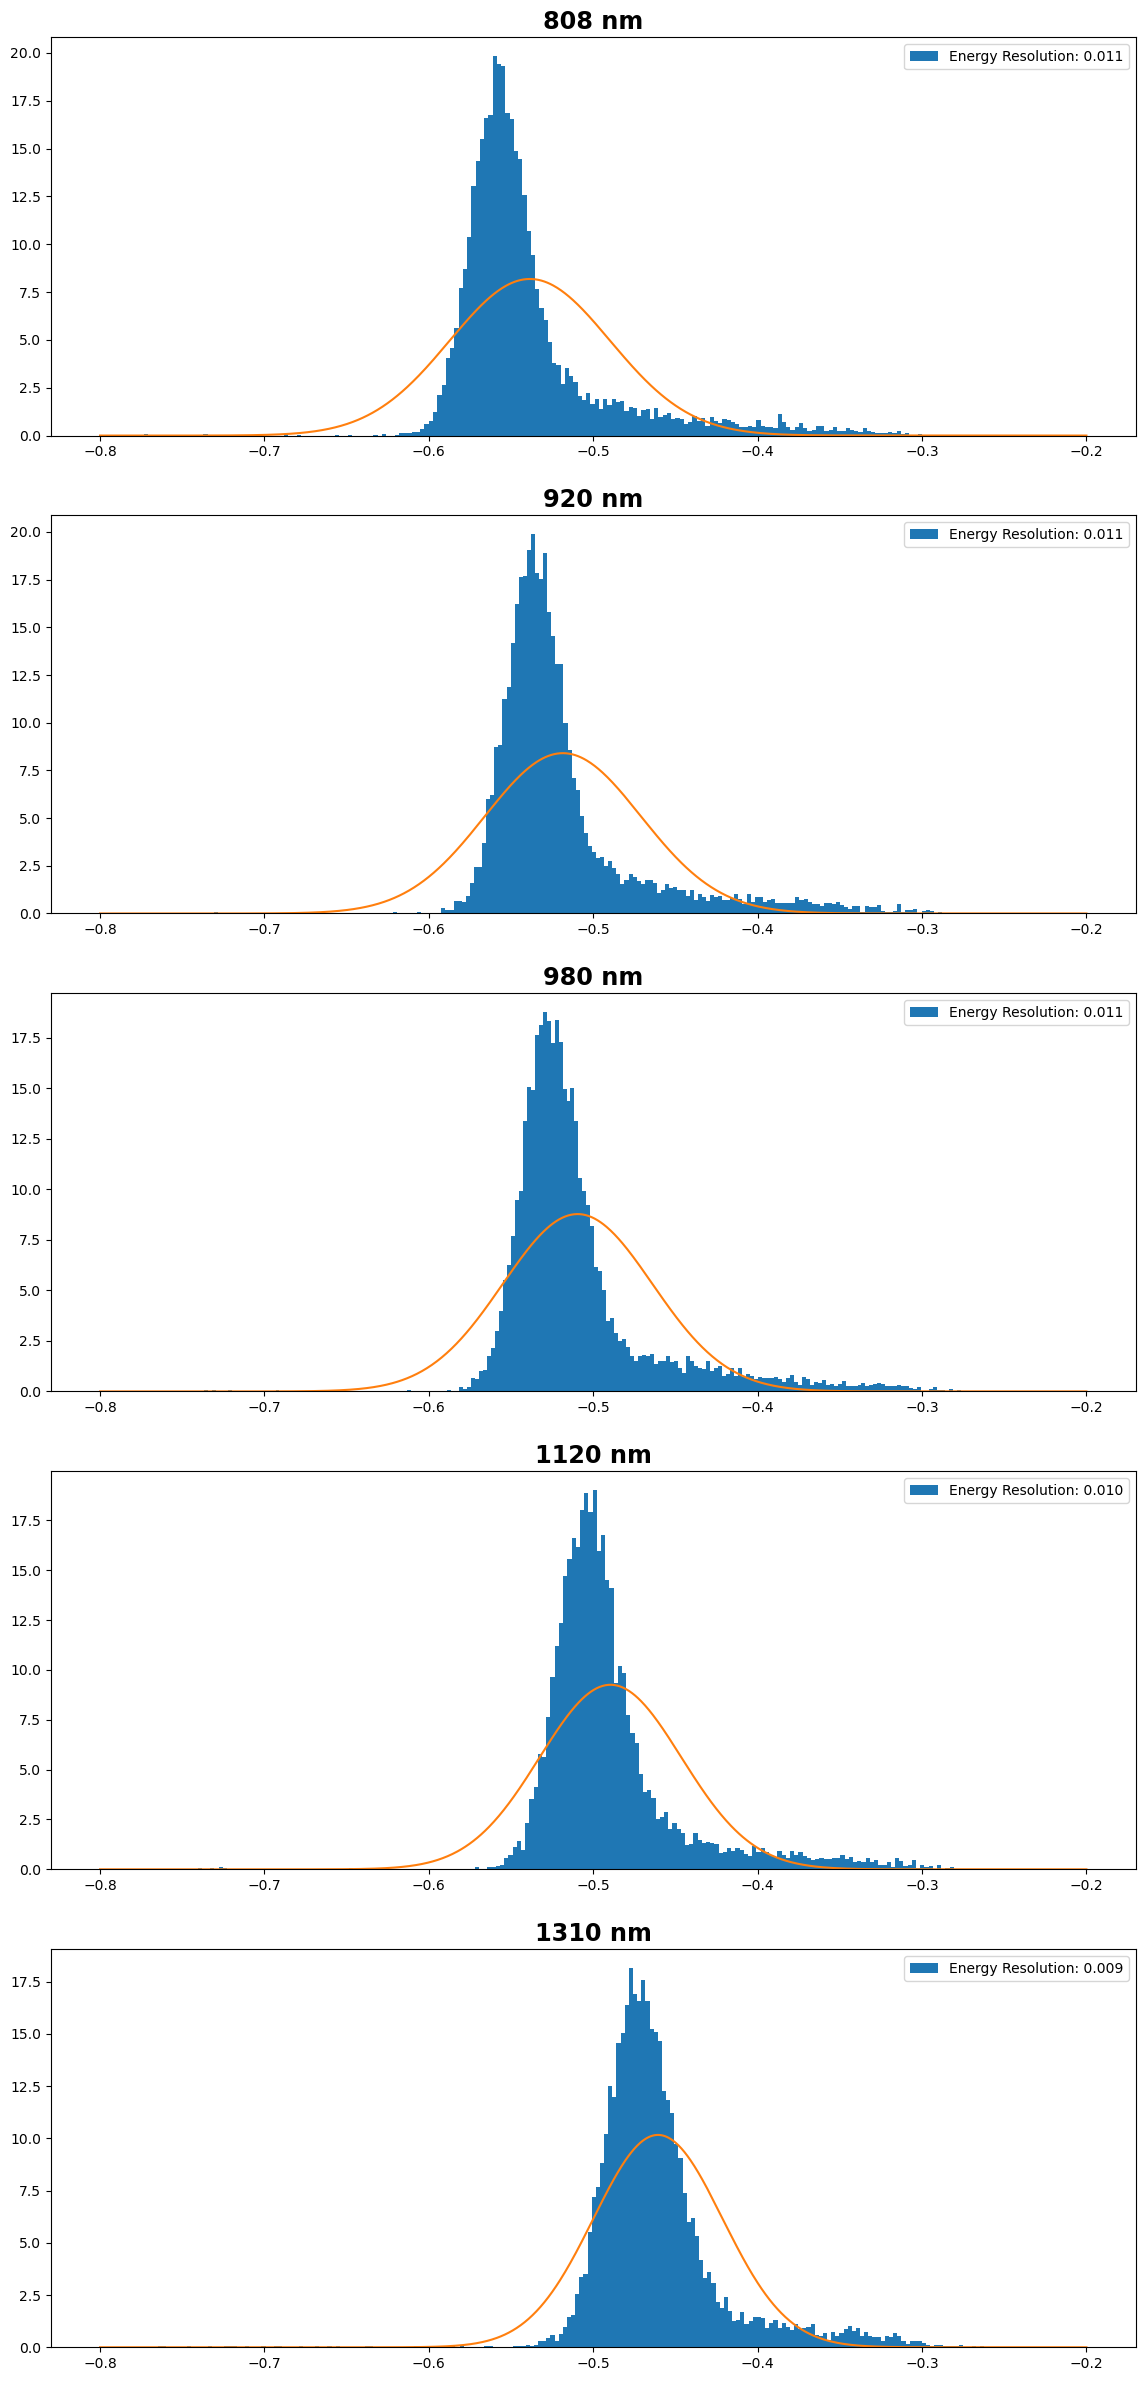

In [74]:
#Plot histogram for each spectra
fig, ax = plt.subplots(5,1, figsize = (14,30))
col = ['808 nm','920 nm','980 nm','1120 nm','1310 nm']

for i in range(5):
  #Generate Gaussians
  var = np.var(peak_heights[i])
  mu = np.mean(peak_heights[i])
  x = np.linspace(-0.2, -0.8, 1000)
  y = np.exp(-(x-mu)**2/(2*var)) #gaussian
  A = 1/np.sqrt(2*np.pi*var) #gaussian normalization constant
  R = np.sqrt(var)*2.35/A #energy resolution
  
  #Plot Gaussians + Histograms
  ax[i].hist(peak_heights[i], bins = 200,density=True,label=f"Energy Resolution: {R:.3f}")
  ax[i].plot(x,A*y)
  ax[i].set_title(col[i], fontweight = "bold", size = 'xx-large')
  ax[i].legend()